In [1]:
using Random, Distributions
using LinearAlgebra, Statistics
using Plots

In [2]:
# Parameters to choose

γ = 0.2
β = 0.8 # 4% interest rate

ρ = 0.866
σ = 0.059
σ_0 = sqrt(σ^2/(1 - ρ^2)) # 0.12
m = 0.088


m_0 = 0.9
f = 20
c_e = 15

sub = [0,10,15,20] # subsidy, k the threshold is 62 from the calibrated model 
k_star = 62;

In [3]:
# Discretize AR(1) - Tauchen Method

function tauchen(m, σ, ρ=0.866, n_std = 7, N = 120)
    # Discretize space
    m_s = m/(1-ρ)
    σ_s = σ/sqrt(1-ρ^2)
    s_min = m_s - n_std * σ_s/2
    s_max = m_s + n_std * σ_s
    log_s = range(s_min, s_max, length = N)
    s = exp.(log_s)
    d = log_s[2] - log_s[1]
    d_half = d/2
    
    # Tranformation matrix
    P = zeros(N,N)
    for i in eachindex(log_s) 
        P[i,1] = cdf(Normal(0,1), (s_min + d_half -ρ*log_s[i]-m)/σ)
        P[i,N] = 1 - cdf(Normal(0,1), (s_max - d_half -ρ*log_s[i]-m)/σ)
        for j in 2:N-1
            P[i,j] = cdf(Normal(0,1), (log_s[j] + d_half -ρ*log_s[i]-m)/σ) - cdf(Normal(0,1), (log_s[j]  - d_half -ρ*log_s[i]-m)/σ)
        end    
    end
    return P,s
end

tauchen (generic function with 4 methods)

In [4]:
(P,s) = tauchen(m, σ);

In [5]:
# Find Value Function

function findV_s(p, V0, P, s, sub, f=20, γ=0.2, β=0.8, max_it = 1e4, tol=1e-8)
    i = 1 
    dist = 1e3
    V = V0
    N = length(s)
    
    # optimal q
    q = (p*s).^(1/γ)
    # profit function
    profit = zeros(N)
    for j in 1:N
        if j <= k_star 
            profit[j] = p*q[j] - (q[j]^(1+γ))/((1+γ)*s[j])-f+sub
        else
            profit[j] = p*q[j] - (q[j]^(1+γ))/((1+γ)*s[j])-f
        end
    end
    
    while (i < max_it) & (dist > tol)
        V1 =  max.(0, profit + β * P'*V)
        dist = norm(V1 - V)
        V = V1
        i += 1
    end
    
    return V
    
end

findV_s (generic function with 6 methods)

In [6]:
function fr_entry_s(p, P, s, g, sub, c_e=15)
    V0 = zeros(N)
    V = findV_s(p, V0, P, s, sub)
    return  β*g'*V - c_e
end

fr_entry_s (generic function with 2 methods)

In [7]:
function eqm_price_s(P, s, g, sub, max_it = 1e3, tol=1e-8)
    p_max = 100
    p_min = 0
    v_e = 1e3
    i = 0
    
    while (i < max_it) & (p_max - p_min > tol)
        p = (p_max + p_min)/2
        v_e = fr_entry_s(p, P, s, g, sub)
        if v_e > 0
            p_max = p
        else
            p_min = p
        end
        i +=1
    end
    
    return p_min
end

eqm_price_s (generic function with 3 methods)

In [8]:
# Exit threshold

function exit_s_s(p, s, P,sub, f=20)
    v = -1
    # optimal q
    q = (p*s).^(1/γ)
    # profit function
    profit = zeros(N)
    for j in 1:N
        if j <= k_star 
            profit[j] = p*q[j] - (q[j]^(1+γ))/((1+γ)*s[j])-f+sub
        else
            profit[j] = p*q[j] - (q[j]^(1+γ))/((1+γ)*s[j])-f
        end
    end
    
    V0 = zeros(N)
    V = profit + β*P'*findV_s(p, V0, P, s, sub)
    
    return sum(V.<0)
end

exit_s_s (generic function with 2 methods)

In [9]:
# moments 

N = length(s)
    
    # Initial distribution
    G = cdf(LogNormal(m_0,σ_0),s)
    g = zeros(N)
    g[1] = G[1]

    for i in 2:N
        g[i] = G[i] - G[i-1]
    end
    g=round.(g/sum(g),digits=4);
    


In [10]:
price = zeros(4)
k_s = zeros(4)
μ = zeros(4,N)
bar_μ = zeros(4,N)
α = zeros(4,5)
q =zeros(4,N)
    

for l in 1:4
    
    price[l] = eqm_price_s(P, s, g, sub[l])   
    
    q[l,:] = (price[l]*s).^(1/γ)
    # Exit rule
    k_s[l] = exit_s_s(price[l],s, P, sub[l])
    x = convert(Int64,k_s[l])
    
    P_tilde = zeros(N,N)
    
    for i in x+1:N
        P_tilde[i,:] = P[i,:]
    end
    
    # Invariant distribution
    μ[l,:]=inv(I-P_tilde')*g
    bar_μ[l,:] =  μ[l,:]/sum(μ[l,:])

    MU = zeros(5,N)
    for i in eachindex(α[l,:])
        MU[i,:] = (P_tilde')^(i) * g
        α[l,i] = sum(MU[i,:])/sum(g)
    end
end

In [11]:
# Survival rates
round.(α,digits=3)

4×5 Array{Float64,2}:
 0.571  0.42   0.304  0.215  0.149
 0.733  0.598  0.477  0.372  0.285
 0.908  0.833  0.749  0.659  0.571
 1.0    1.0    1.0    1.0    1.0

In [12]:
# exit threshold
k_s'

1×4 Adjoint{Float64,Array{Float64,1}}:
 62.0  57.0  49.0  2.0

In [13]:
# Turnover rate in model: Entry/All firms i.e. λ/μ(S)

print("0:", 1/sum(α[1,:])," 10:", 1/sum(α[2,:])," 15:", 1/sum(α[3,:])," 20:", 1/sum(α[4,:]))

0:0.6025740546961846 10:0.405795780043597 15:0.2687971122184949 20:0.20000016499582093

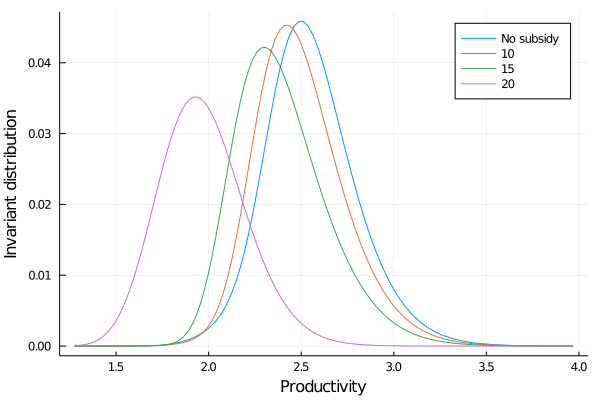

In [14]:
# Invariant distribution of productivity

plot3 = plot(s[1:110],bar_μ[1,1:110],label = "No subsidy" ) 
plot!(s[1:110],bar_μ[2,1:110],label = "10" )
plot!(s[1:110],bar_μ[3,1:110],label = "15" ) 
plot!(s[1:110],bar_μ[4,1:110],label = "20" )
xlabel!("Productivity")
ylabel!("Invariant distribution")
#savefig(plot3,"plot3.png")

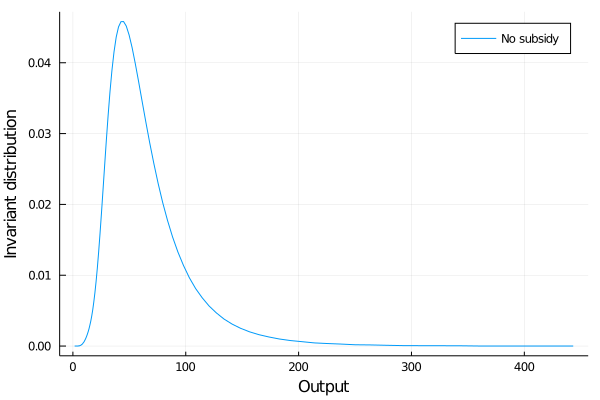

In [15]:
# Invariant distribution of firm size (in terms of output)
plot41 =plot(q[1,1:110],bar_μ[1,1:110],label = "No subsidy"  )  
xlabel!("Output")
ylabel!("Invariant distribution")
#savefig(plot41,"plot4_1.png")

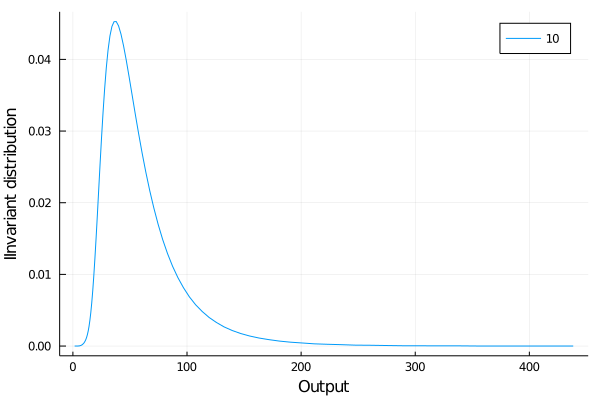

In [16]:
# Invariant distribution of firm size (in terms of output)
plot42 =plot(q[2,1:110],bar_μ[2,1:110],label = "10"  )  
xlabel!("Output")
ylabel!("IInvariant distribution")
#savefig(plot42,"plot4_2.png")

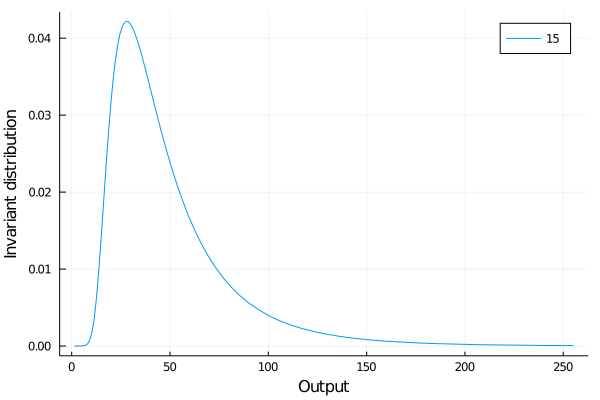

In [17]:
# Invariant distribution of firm size (in terms of output)
plot43 =plot(q[3,1:100],bar_μ[3,1:100],label = "15"  )  
xlabel!("Output")
ylabel!("Invariant distribution")
#savefig(plot43,"plot4_3.png")

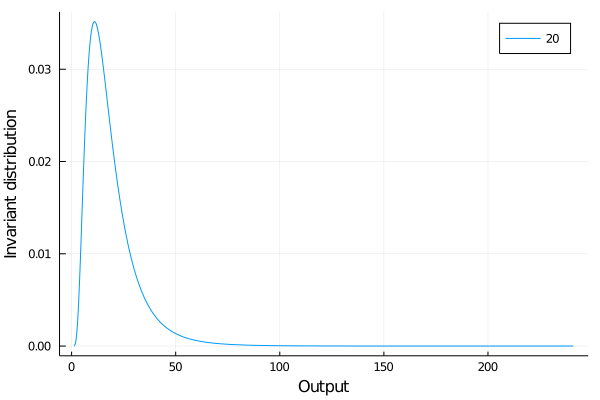

In [18]:
# Invariant distribution of firm size (in terms of output)
plot44 =plot(q[4,1:100],bar_μ[4,1:100],label = "20"  )  
xlabel!("Output")
ylabel!("Invariant distribution")
#savefig(plot44,"plot4_4.png")

In [19]:
# Demand: Q = 10/p -1
Q = 10 ./ price .- 1

# Consumer surplus
CS = 10 *log.(Q .+ 1) - price.*Q

4-element Array{Float64,1}:
 15.474985545270773
 15.49524622943515
 15.53401442397124
 15.63825143676241

In [20]:
# Producer surplus 
λ = zeros(4)
PS = zeros(4)

for i in 1:4
    λ[i] = Q[i]/sum(μ[i,:])
    PS[i] =λ[i]*dot( μ[i,:],(price[i]*q[1,:]- (q[i,:].^(1+γ))./((1+γ)*s)))
end

TS = CS.+PS

4-element Array{Float64,1}:
 93.77545418892987
 89.46437917965636
 81.92837189961497
 46.933013641835345

In [21]:
PS

4-element Array{Float64,1}:
 78.3004686436591
 73.96913295022121
 66.39435747564373
 31.294762205072935